In [1]:
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.config = args
print(dl.inpath)
print(dl.outpath)

from asap.data import sim

N=1000
P=2000
K=10

H = sim.generate_H(N, K)
W = sim.generate_W(P, K)
R = np.matmul(H, W.T) 
X = np.random.poisson(R)

dl.mtx = np.asmatrix(X)
dl.rows = ['c_'+str(i) for i in range(N) ]
dl.cols = ['g_'+str(i) for i in range(P) ]

/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/simdata


In [2]:
from asap.annotation import ASAPNMF
import asapc 

asap = ASAPNMF(adata=dl)
asap.get_pbulk()
asap.pbulk_mat.shape

(419, 2000)

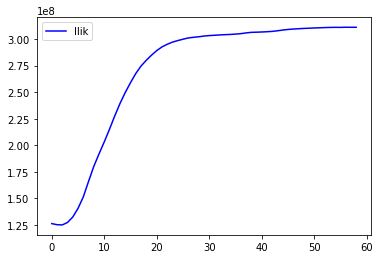

In [3]:
K = 10
nmf_model = asapc.ASAPaltNMF(asap.pbulk_mat.T,K)
nmf = nmf_model.nmf()

plt.plot(nmf.llik_trace,'b',label='llik')
plt.legend()

In [4]:
nmf.beta.shape

(2000, 10)

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


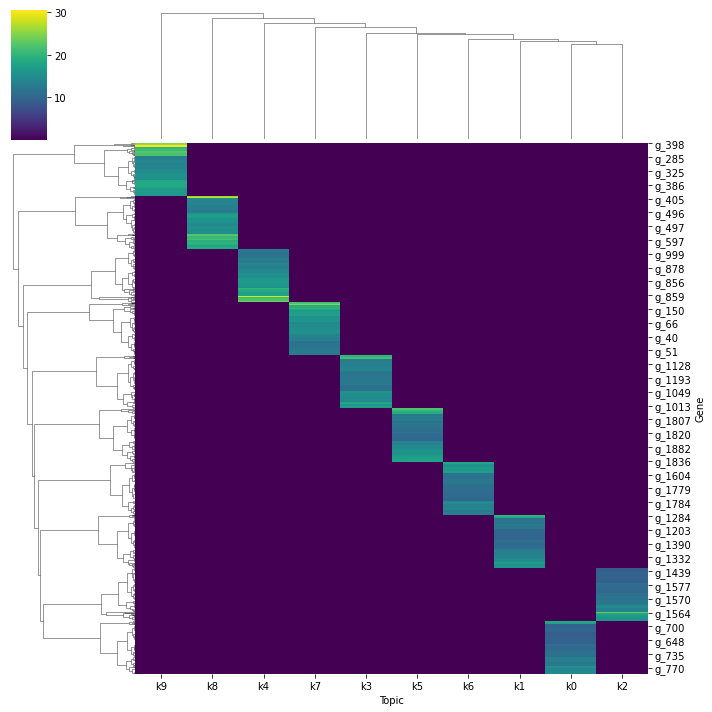

In [5]:
df_beta = pd.DataFrame(nmf.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [ ]:
regm = asapc.ASAPaltNMFPredict(dl.mtx.T,nmf.beta_log)
reg = regm.predict()

/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


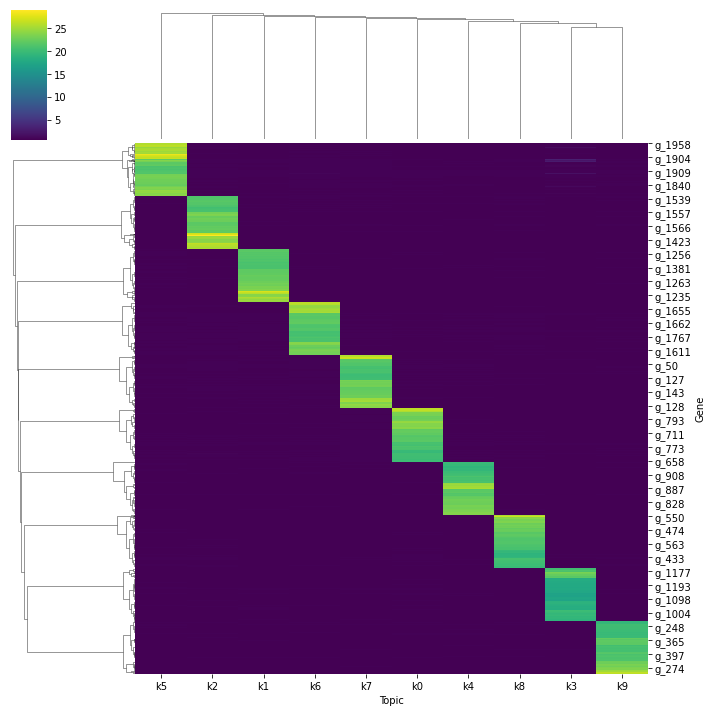

In [8]:
df_beta = pd.DataFrame(reg.beta.T)

df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

# df_top[df_top>100] = 100
sns.clustermap(df_top.T,cmap='viridis')

In [12]:
import umap
df_theta = pd.DataFrame(reg.corr)
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.0,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,c_0,9,4.991287,6.671636
1,c_1,9,5.723548,6.866422
2,c_2,3,2.621665,9.157694
3,c_3,4,2.681440,2.673681
4,c_4,0,3.343463,7.244483
...,...,...,...,...
995,c_995,1,6.306316,4.166715
996,c_996,6,6.616226,4.342265
997,c_997,9,4.872396,6.142869
998,c_998,0,2.666645,3.044222


Text(0, 0.5, 'UMAP2')

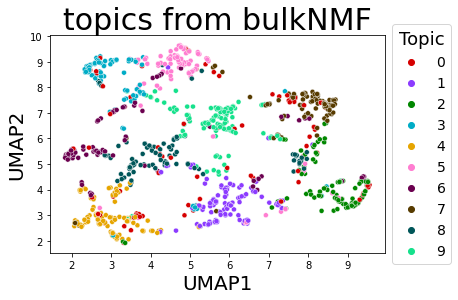

In [13]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=25,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)